# Warpy: open-source Farcaster datasets

By running `python download.py`, you can download the Farcaster datasets. This notebook will walk you through the things you can do with it.


In [2]:
import os
import duckdb

# if ./datasets exists (and the stuff inside exists, continue, else print error message)
if not os.path.exists('./datasets'):
    print('Datasets folder does not exist, please run `python download.py`')
else:
    print('Datasets folder exists, continuing...')

Datasets folder exists, continuing...


In [10]:
# you can use duckdb to directly query the files with SQL
query = "select * from read_parquet('./datasets/users.parquet') order by random() limit 5"
print(duckdb.query(query).pl())

# Note: to use ChatGPT to write query for you, see query.py
# ex: `python query.py "get ten random users"`

shape: (5, 5)
┌───────┬──────────┬──────────────┬────────────────────────────────┬───────────────────────────────┐
│ fid   ┆ username ┆ display_name ┆ pfp_url                        ┆ bio_text                      │
│ ---   ┆ ---      ┆ ---          ┆ ---                            ┆ ---                           │
│ i64   ┆ str      ┆ str          ┆ str                            ┆ str                           │
╞═══════╪══════════╪══════════════╪════════════════════════════════╪═══════════════════════════════╡
│ 2105  ┆ lacrosse ┆ Connor Emma  ┆ https://i.imgur.com/7wNtqNt.jp ┆ Engineer @coinbase |          │
│       ┆          ┆              ┆ g                              ┆ Co-Founder …                  │
│ 3668  ┆ vector19 ┆ Avi Ahuja    ┆ https://pbs.twimg.com/profile_ ┆ tokenization maxi - product @ │
│       ┆          ┆              ┆ im…                            ┆ cr…                           │
│ 8045  ┆ doug     ┆ Doug         ┆ https://i.imgur.com/zchWBCY.jp ┆ Noob    

In [12]:
# here's a fancier query: get all farcasters in new york
query = "SELECT * FROM read_parquet('datasets/users.parquet') u JOIN read_parquet('datasets/user_extra.parquet') ue ON u.fid = ue.fid JOIN read_parquet('datasets/locations.parquet') l ON ue.location_id = l.id WHERE LOWER(l.description) LIKE '%new york%'"

users = duckdb.query(query).pl()
print(users)


shape: (101, 14)
┌───────┬───────────┬────────────┬───────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ fid   ┆ username  ┆ display_na ┆ pfp_url   ┆ … ┆ external_a ┆ registered ┆ id        ┆ descripti │
│ ---   ┆ ---       ┆ me         ┆ ---       ┆   ┆ ddress     ┆ _at        ┆ ---       ┆ on        │
│ i64   ┆ str       ┆ ---        ┆ str       ┆   ┆ ---        ┆ ---        ┆ str       ┆ ---       │
│       ┆           ┆ str        ┆           ┆   ┆ str        ┆ i64        ┆           ┆ str       │
╞═══════╪═══════════╪════════════╪═══════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 11165 ┆ liujitsu  ┆ roy        ┆ https://i ┆ … ┆ null       ┆ -1         ┆ ChIJOwg_0 ┆ New York, │
│       ┆           ┆            ┆ .seadn.io ┆   ┆            ┆            ┆ 6VPwokRYv ┆ NY, USA   │
│       ┆           ┆            ┆ /gcs/file ┆   ┆            ┆            ┆ 534QaPC8g ┆           │
│       ┆           ┆            ┆ s/2a3…    ┆   ┆            ┆           

In [33]:
# you can also use pandas or polars to process things
# ex: get all users where they have at least 5 casts that contain "gjelina" or "erewhon" 
import polars as pl

cast_query = "select * from read_parquet('datasets/casts*.parquet')"
cast_df = duckdb.query(cast_query).df()

# get all users where they have at least 5 casts that contain "gjelina" or "erewhon"
cast_df = cast_df[cast_df['text'].str.contains('gjelina|erewhon', case=False)]
cast_df = cast_df.groupby('author_fid').filter(lambda x: len(x) >= 5)
print(pl.DataFrame._from_pandas(cast_df))

# get the user info, then print it out
fids = cast_df['author_fid'].unique()
user_query = "select * from read_parquet('datasets/users.parquet')"
users_df = duckdb.query(user_query).df()
users_df = users_df[users_df['fid'].isin(fids)]
print(pl.DataFrame._from_pandas(users_df))


shape: (60, 8)
┌──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬────────────┬──────┬───────┐
│ hash         ┆ thread_hash ┆ parent_hash ┆ text        ┆ timestamp   ┆ author_fid ┆ year ┆ month │
│ ---          ┆ ---         ┆ ---         ┆ ---         ┆ ---         ┆ ---        ┆ ---  ┆ ---   │
│ str          ┆ str         ┆ str         ┆ str         ┆ i64         ┆ i64        ┆ i32  ┆ i32   │
╞══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪════════════╪══════╪═══════╡
│ 0xd913c70968 ┆ 0xa75522564 ┆ 0x82939b1b7 ┆ @v you      ┆ 16421976460 ┆ 3          ┆ 2022 ┆ 1     │
│ 1ed094c979ee ┆ a7613a5b89e ┆ c8eeea68cd1 ┆ should get  ┆ 67          ┆            ┆      ┆       │
│ 2c09ec47…    ┆ 82c7f2fb3a… ┆ a984a3351f… ┆ a coffee    ┆             ┆            ┆      ┆       │
│              ┆             ┆             ┆ mug o…      ┆             ┆            ┆      ┆       │
│ 0xf75a80ff9b ┆ 0xceae07d6f ┆ 0xceae07d6f ┆ Erewhon!    ┆ 16475438621 ┆ 3  

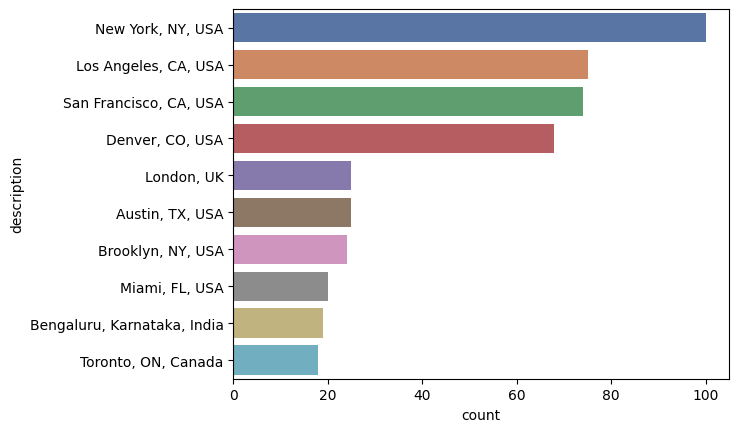

In [50]:
# you can also use seaborn/matplotlib to visualize things
# ex: plot top 10 farcasters' most frequent locations
import seaborn as sns
import matplotlib.pyplot as plt

# get top 10 farcasters' most frequent locations
query = """
SELECT l.description, COUNT(*) AS count
FROM read_parquet('datasets/locations.parquet') l
JOIN read_parquet('datasets/user_extra.parquet') ue ON l.id = ue.location_id
GROUP BY l.description
ORDER BY count DESC
LIMIT 10;
"""
df = duckdb.query(query).df()
sns.barplot(x='count', y='description', data=df, palette="deep")
plt.show()


I hope you enjoy using Warpy!

Complaints, comments, feedback to go @pixel on Farcaster :)
